In [5]:
reset -fs

In [6]:
import numpy as np
import tensorflow as tf
import pandas as pd
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
%matplotlib inline

In [7]:
def preprocess(filepath,ml):
    c = []
    if ml == 0:
        ml = 1000
    with open(filepath,'r') as f:
        for line in f:
            line = line.replace('\n','')
            s = 0
            c.append([int(line.split()[i]) for i in range(len(line.split())) if i<ml])
    return c

def final_preprocess(c):   #padding
    max_l = max([len(i) for i in c])
    for i in range(len(c)):
        c[i] = c[i] + (max_l-len(c[i]))*[0]
    return c,max_l

In [8]:
#reading train data and preprocessing them + padding
#pad the context and question data
context_data,max_l_context = final_preprocess(preprocess('data/train.ids.context',600))
question_data,max_l_question = final_preprocess(preprocess('data/train.ids.question',0))
answer_data = preprocess('data/train.span',0)
answer_start_data = [i[0] for i in answer_data]
answer_end_data = [i[1] for i in answer_data]

In [9]:
with open('data/train.ids.question', 'r') as f:
    result = []
    for line in f:
        result.append(len(line.split()))

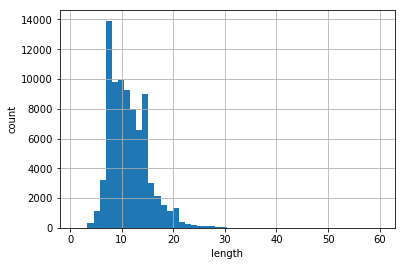

In [10]:
pd.Series(data=result).hist(bins=50)
plt.xlabel('length')
plt.ylabel('count')

In [11]:
len(question_data[0])

60

In [12]:
print (max_l_context)
print (max_l_question)

600
60


In [13]:
def length(sequence):
    used = tf.sign(tf.reduce_max(tf.abs(sequence), axis=2))
    length = tf.reduce_sum(used, axis=1)
    length = tf.cast(length, tf.int32)
    #print "sequence length tf shape:",length.shape
    return length

In [14]:
#encoder function
def encoder(question,context,embeddings,hidden_units=200):
    batch_size = tf.shape(question)[0]
    #question and document encoder
    q_embedding = tf.nn.embedding_lookup(embeddings,question)
    d_embedding = tf.nn.embedding_lookup(embeddings,context)
    
    print (q_embedding.shape,"=?,60,100")
    print (d_embedding.shape,"=?,600,100")
    
    lstm_enc = tf.contrib.rnn.BasicLSTMCell(hidden_units)
    
    with tf.variable_scope('document_encoder') as scope1:
        document_states,_ = tf.nn.dynamic_rnn(cell=lstm_enc,
                                              dtype=tf.float32,
                                              inputs=d_embedding,
                                              sequence_length=length(q_embedding),
                                              time_major=False)
        
    with tf.variable_scope('question_encoder') as scope2:
        question_states,_ = tf.nn.dynamic_rnn(cell=lstm_enc,
                                              dtype=tf.float32,
                                              inputs=q_embedding,
                                              sequence_length=length(d_embedding),
                                              time_major=False)

    Wq = tf.get_variable(name="Wq",shape=[hidden_units,hidden_units],initializer=tf.contrib.layers.xavier_initializer(),dtype=tf.float32)
    bq = tf.Variable(tf.constant(0.0,shape=[hidden_units,]),dtype=tf.float32,name='bq')
    Wq = tf.expand_dims(tf.ones([batch_size,1]), 1) * Wq
    #question_states_new = tf.reshape(question_states,shape=[-1,hidden_units])
    print (document_states.shape,"=?,600,200")
    print (question_states.shape,"=?,60,200")
    #print question_states_new.shape,"=?,200"
    print (Wq.shape,"=?,200,200")
    print (bq.shape,"=200,")
    
                    
    question_states_modified_duplicate = tf.nn.tanh(tf.matmul(question_states,Wq)+bq)
    #question_states_modified_duplicate = tf.reshape(question_states_modified,shape=[-1,int(question_states.shape[1]),hidden_units])
    question_states_modified = tf.transpose(question_states_modified_duplicate,perm=[0,2,1]) #tf.reshape(question_states_modified,shape=[-1,hidden_units,int(question_states.shape[1])])
    print (question_states_modified.shape,"=?,200,60")
    print (question_states_modified_duplicate.shape,"=?,60,200")

    #coattention encoder
    
    l = tf.matmul(document_states,question_states_modified)
    print (l.shape,"=?,600,60")
    aq = tf.nn.softmax(l)
    ad = tf.nn.softmax(tf.transpose(l,perm=[0, 2, 1]))
    print (aq.shape,"=?,600,60")
    print (ad.shape,"=?,60,600")
    
    cq = tf.matmul(tf.transpose(aq,perm=[0,2,1]),document_states)
    print (cq.shape,"=?,60,200")
    print (question_states_modified_duplicate.shape,"=?,60,200")
    qcq = tf.concat([question_states_modified_duplicate,cq],2)
    print (qcq.shape,"=?,60,400")
    cd = (tf.matmul(tf.transpose(ad,perm=[0,2,1]),qcq))
    print (cd.shape,"=?,600,400")
    dcd = tf.concat([document_states,cd],axis=2)
    print (dcd.shape,"=?,600,600")
    
    with tf.variable_scope('coattention'):
        u_lstm_fw = tf.contrib.rnn.BasicLSTMCell(hidden_units)  #bi-lstm
        u_lstm_bw = tf.contrib.rnn.BasicLSTMCell(hidden_units)
        u_states,_ = tf.nn.bidirectional_dynamic_rnn(cell_bw=u_lstm_bw,cell_fw=u_lstm_fw,dtype=tf.float32,inputs=dcd,time_major=False,sequence_length=length(dcd))
    encoder_states = tf.concat(u_states,2)
    print (encoder_states.shape)
    return encoder_states

In [15]:
#decoder function
def decoder(knowledge_reps,hidden_units = 200):
    #randomly initialise s and e
    batch_size = tf.shape(knowledge_reps)[0]
    #print batch_size
    pool = 16
    e = np.random.randint(max_l_context) + 1
    s = np.random.randint(e)
    sv = tf.tile([s],[batch_size])
    ev = tf.tile([e],[batch_size])

    #lstm cell
    #with tf.variable_scope('lstm_dec') as scope_dec:
    lstm_dec = tf.contrib.rnn.LSTMCell(hidden_units)
    ch = lstm_dec.zero_state(batch_size,dtype=tf.float32)
    hi,ci = ch
    
    
    with tf.variable_scope('hmn1') as scope1:
        wd = tf.get_variable(name="wd",shape=[hidden_units,5*hidden_units],initializer=tf.contrib.layers.xavier_initializer(),dtype=tf.float32)
        w1 = tf.get_variable(name="w1",shape=[pool*hidden_units,3*hidden_units],initializer=tf.contrib.layers.xavier_initializer(),dtype=tf.float32)
        w2 = tf.get_variable(name="w2",shape=[pool*hidden_units,hidden_units],initializer=tf.contrib.layers.xavier_initializer(),dtype=tf.float32)
        w3 = tf.get_variable(name="w3",shape=[pool,2*hidden_units],initializer=tf.contrib.layers.xavier_initializer(),dtype=tf.float32)
    
    with tf.variable_scope('hmn2') as scope2:
        wd = tf.get_variable(name="wd",shape=[hidden_units,5*hidden_units],initializer=tf.contrib.layers.xavier_initializer(),dtype=tf.float32)
        w1 = tf.get_variable(name="w1",shape=[pool*hidden_units,3*hidden_units],initializer=tf.contrib.layers.xavier_initializer(),dtype=tf.float32)
        w2 = tf.get_variable(name="w2",shape=[pool*hidden_units,hidden_units],initializer=tf.contrib.layers.xavier_initializer(),dtype=tf.float32)
        w3 = tf.get_variable(name="w3",shape=[pool,2*hidden_units],initializer=tf.contrib.layers.xavier_initializer(),dtype=tf.float32)

        
    #loop 4 times to call lstm cell to:
    for i in range(4):
        #concatenate u_s and u_e
        u_s = tf.gather_nd(params=knowledge_reps,indices=tf.stack([tf.range(batch_size,dtype=tf.int32),sv],axis=1))
        u_e = tf.gather_nd(params=knowledge_reps,indices=tf.stack([tf.range(batch_size,dtype=tf.int32),ev],axis=1))
        usue = tf.concat([u_s,u_e],axis=1)
        print (i,usue.shape,hi.shape)
        #calculate hi
         
        with tf.variable_scope("hmn1",reuse=True) as scope1:
            sv,hmns_output = hmn(knowledge_reps,hi,u_s,u_e,hidden_units,pool)#loop over the document length times to obtain alpha t using HNM function
        with tf.variable_scope("hmn2",reuse=True) as scope2:
            ev,hmne_output = hmn(knowledge_reps,hi,u_s,u_e,hidden_units,pool)#loop over the document length times to obtain beta t using HNM function
        
        hi,ch = lstm_dec(inputs=usue,state=ch) 
        
    return sv,ev,hmns_output,hmne_output

In [16]:
def hmn(kr,hs,us,ue,hidden_units,pool=16):
    
    #print "kr",kr.shape
    #calculate r
    wd = tf.get_variable(name="wd",shape=[hidden_units,5*hidden_units],initializer=tf.contrib.layers.xavier_initializer(),dtype=tf.float32)
    x = tf.concat([hs,us,ue],axis=1)
    r = tf.nn.tanh(tf.matmul(x,tf.transpose(wd)))
    #print r.shape

    #calculate mt1
    r1 = tf.expand_dims(tf.ones([int(kr.shape[1]),1]), 1) * r
    r1 = tf.reshape(r1,[-1,hidden_units])
    kr1 = tf.reshape(kr,[-1,2*hidden_units])
    krr1 = tf.concat([kr1,r1],axis=1)
    w1 = tf.get_variable(name="w1",shape=[pool*hidden_units,3*hidden_units],initializer=tf.contrib.layers.xavier_initializer(),dtype=tf.float32)
    b1 = tf.Variable(tf.constant(0.0,shape=[pool*hidden_units,]),dtype=tf.float32)
    x1 = tf.matmul(krr1,tf.transpose(w1))+b1
    x1 = tf.reshape(x1,[-1,pool])
    x1 = tf.reduce_max(x1,axis=1)
    m1 = tf.reshape(x1,[-1,hidden_units])
    #print m1.shape
    
    #calculate mt2
    w2 = tf.get_variable(name="w2",shape=[pool*hidden_units,hidden_units],initializer=tf.contrib.layers.xavier_initializer(),dtype=tf.float32)
    b2 = tf.Variable(tf.constant(0.0,shape=[pool*hidden_units,]),dtype=tf.float32)
    x2 = tf.matmul(m1,tf.transpose(w2))+b2
    x2 = tf.reshape(x2,[-1,pool])
    x2 = tf.reduce_max(x2,axis=1)
    m2 = tf.reshape(x2,[-1,hidden_units])
    #print m2.shape
    
    #max
    m1m2 = tf.concat([m1,m2],axis=1)
    #print "m1m2",m1m2.shape
    w3 = tf.get_variable(name="w3",shape=[pool,2*hidden_units],initializer=tf.contrib.layers.xavier_initializer(),dtype=tf.float32)
    b3 = tf.Variable(tf.constant(0.0,shape=[pool,]),dtype=tf.float32)
    x3 = tf.matmul(m1m2,tf.transpose(w3))+b3
    #print x3.shape
    x3 = tf.reduce_max(x3,axis=1)
    #print x3.shape
    x3 = tf.reshape(x3,[-1,int(kr.shape[1])])
    #print "x3",x3.shape
    #argmax
    output = tf.argmax(x3,axis=1)
    output = tf.cast(output,dtype=tf.int32)
    
    return output,x3

In [17]:
#read embedding file
embedding_array = np.load('data/glove.trimmed.100.npz')

In [18]:
embedding_array['glove'][0]

array([ 0.52058829, -0.51654186,  0.27968494, -1.81354095, -0.24410476,
       -0.68052369, -0.00260126, -1.15966041,  0.13565797, -2.03933159,
        1.39574077, -0.41010746,  0.78249643, -0.03234985,  1.49243316,
        0.58828367, -0.12553187,  2.22018055, -0.45500756,  0.89039387,
       -0.18749341,  0.1809392 ,  0.29886465, -0.24914736, -0.49023885,
       -1.01622756,  1.8752643 ,  0.44214767,  1.33379188, -1.34961692,
       -0.01415288, -0.59999874, -0.81665375,  2.37627875, -0.4235163 ,
        0.57595554,  0.59935966,  0.02639429, -0.26178128,  0.4963044 ,
        1.88299358, -0.46125415,  0.6598317 ,  2.18697996, -1.18201243,
       -1.56485642,  0.71330753,  0.43130444,  0.24754809,  1.52875936,
        0.12049194,  1.81434007,  0.11948352, -0.17062094,  0.26578507,
       -0.38349847,  1.14144629,  1.74730465,  0.12359092, -0.68782479,
       -0.71124553,  0.11059589, -1.03285808,  0.62593014, -0.68293404,
        0.45794549, -1.84091036,  1.27705293, -0.24747408,  0.10

In [19]:
## create placeholders
tf.reset_default_graph()
hidden_units = 200
question = tf.placeholder(dtype=tf.int32,shape=[None,max_l_question])
context = tf.placeholder(dtype=tf.int32,shape=[None,max_l_context])
answer_start = tf.placeholder(dtype=tf.int32,shape=[None])
answer_end = tf.placeholder(dtype=tf.int32,shape=[None])
embeddings = tf.constant(embedding_array['glove'],dtype=tf.float32)

encoder_states = encoder(question,context,embeddings)
print ("decoder starts")
decoder_output_start, decoder_output_end, hmns_output, hmne_output = decoder(encoder_states)

## add loss
l1 = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=answer_start,logits=hmns_output)
l2 = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=answer_end,logits=hmne_output)
loss = l1 + l2

# print "hmns_output.shape: ",hmns_output.shape
# ## EM accuracy
pred_start = tf.argmax(hmns_output, 1)
# pred_start_v = tf.expand_dims(pred_start, 1)
pred_end = tf.argmax(hmne_output, 1)
# pred_end_v = tf.expand_dims(pred_end, 1)
# pred = tf.gather_nd(question, )

# answer_start_v = tf.expand_dims(answer_start, 1)
# answer_end_v = tf.expand_dims(answer_end, 1)

# print "question.shape: ",question.shape
# print "pred_start.shape: ",pred_start.shape
# print "answers.shape",tf.gather_nd(question, answer_start_v).shape
# print "tf.equal shape: ",tf.equal(tf.gather_nd(context, pred_start_v), tf.gather_nd(context, answer_start_v)).shape
# EM_acc = tf.logical_and(tf.equal(tf.gather_nd(context, pred_start_v), tf.gather_nd(context, answer_start_v)), 
#                         tf.equal(tf.gather_nd(context, pred_end_v), tf.gather_nd(context, answer_end_v))
#                        )
# EM_acc = tf.cast(EM_acc, tf.int32)
# EM_acc = tf.reduce_mean(tf.reduce_min(EM_acc, axis=1))
# print "EM_acc.shape: ",EM_acc.shape

## F1 Score


## add optimizer
train_op = tf.train.AdamOptimizer(0.0001).minimize(loss)

(TensorShape([Dimension(None), Dimension(60), Dimension(100)]), '=?,60,100')
(TensorShape([Dimension(None), Dimension(600), Dimension(100)]), '=?,600,100')
(TensorShape([Dimension(None), Dimension(600), Dimension(200)]), '=?,600,200')
(TensorShape([Dimension(None), Dimension(60), Dimension(200)]), '=?,60,200')
(TensorShape([Dimension(None), Dimension(200), Dimension(200)]), '=?,200,200')
(TensorShape([Dimension(200)]), '=200,')
(TensorShape([Dimension(None), Dimension(200), Dimension(60)]), '=?,200,60')
(TensorShape([Dimension(None), Dimension(60), Dimension(200)]), '=?,60,200')
(TensorShape([Dimension(None), Dimension(600), Dimension(60)]), '=?,600,60')
(TensorShape([Dimension(None), Dimension(600), Dimension(60)]), '=?,600,60')
(TensorShape([Dimension(None), Dimension(60), Dimension(600)]), '=?,60,600')
(TensorShape([Dimension(None), Dimension(60), Dimension(200)]), '=?,60,200')
(TensorShape([Dimension(None), Dimension(60), Dimension(200)]), '=?,60,200')
(TensorShape([Dimension(None)

In [20]:
from collections import Counter
def evaluate(context, predict_start, predict_end, answer_start, answer_end):
    f1_scores = []
    em_scores = []
    for i, vector in enumerate(context):
        prediction_tokens = vector[predict_start[i]:predict_end[i]+1]
        ground_truth_tokens = vector[answer_start[i]:answer_end[i]+1]
        common = Counter(prediction_tokens) & Counter(ground_truth_tokens)
        num_same = sum(common.values())
        if num_same == 0:
            f1_scores.append(0)
            continue
        precision = 1.0 * num_same / len(prediction_tokens)
        recall = 1.0 * num_same / len(ground_truth_tokens)
        f1 = (2 * precision * recall) / (precision + recall)
        em = np.min(prediction_tokens == ground_truth_tokens)
        f1_scores.append(f1)
        em_scores.append(em)
    return np.mean(f1_scores), np.mean(em_scores)

evaluate(context_data, answer_start_data, answer_end_data,answer_start_data, answer_end_data )

(0.99927521098731009, 1.0)

In [21]:
#initialise variables and train
init = tf.global_variables_initializer()

In [ ]:
#session run train
validation_size = 100
with tf.Session() as sess:
    sess.run(init)
    batch_size = 128
    for epocs in range(100):
        counter = 0
        for steps in range(318):
            question_batch = np.array(question_data[counter:(counter+batch_size)])
            context_batch = np.array(context_data[counter:(counter+batch_size)])
            answer_start_batch = np.array(answer_start_data[counter:(counter+batch_size)])
            answer_end_batch = np.array(answer_end_data[counter:(counter+batch_size)])
            
            _, pred_start_batch, pred_end_batch = sess.run([train_op, pred_start, pred_end], feed_dict = {question : question_batch, context : context_batch, answer_start : answer_start_batch, answer_end : answer_end_batch})
            f1, em = evaluate(context_batch, pred_start_batch,pred_end_batch, answer_start_batch, answer_end_batch)
            print ("=" * 20)
            print ("step = ", steps)
            print ("F1 Score = ", f1)
            print ("EM score = ", em)
                
            if steps % 100 == 0:
                Q_val = np.array(question_data[-validation_size:])
                D_val = np.array(context_data[-validation_size:])
                A_start = np.array(answer_start_data[-validation_size:])
                A_end = np.array(answer_end_data[-validation_size:])
                loss_val, pred_start_val, pred_end_val = sess.run([loss,pred_start,pred_end], feed_dict = {question : Q_val, context : D_val, answer_start : A_start, answer_end : A_end})
                f1_val, em_val = evaluate(D_val,pred_start_val,pred_end_val, A_start,A_end)
                print ("-"*20)
                print ("Validation Step = ", steps)
                print ("Validation F1 Score = ", f1_val)
                print ("Validation EM Score = ", em_val)
                
            counter = counter + batch_size

/home/tristan/anaconda3/envs/nlp-final/lib/python2.7/site-packages/ipykernel_launcher.py:16: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.
  app.launch_new_instance()


('step = ', 0)
('F1 Score = ', 0.013477533159808906)
('EM score = ', 0.0)
--------------------
('Validation Step = ', 0)
('Validation F1 Score = ', 0.013874458874458874)
('Validation EM Score = ', 0.0)
('step = ', 1)
('F1 Score = ', 0.024271191615231492)
('EM score = ', 0.0)
('step = ', 2)
('F1 Score = ', 0.035479604137692369)
('EM score = ', 0.0)
('step = ', 3)
('F1 Score = ', 0.018645478351660416)
('EM score = ', 0.0)
('step = ', 4)
('F1 Score = ', 0.033811225671104707)
('EM score = ', 0.0)
('step = ', 5)
('F1 Score = ', 0.01599798175392279)
('EM score = ', 0.0)
('step = ', 6)
('F1 Score = ', 0.016229407806783003)
('EM score = ', 0.0)
('step = ', 7)
('F1 Score = ', 0.014736149267399268)
('EM score = ', 0.0)
('step = ', 8)
('F1 Score = ', 0.0095703125000000007)
('EM score = ', 0.0)
('step = ', 9)
('F1 Score = ', 0.019702722797798038)
('EM score = ', 0.0)
('step = ', 10)
('F1 Score = ', 0.017126921410326582)
('EM score = ', 0.0)
('step = ', 11)
('F1 Score = ', 0.008055132972729322)
('E

In [ ]:
#read validation and test files
#preprocess them